In [158]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import math
import glob
import json
import glob
import seaborn as sns
import time
import shutil
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility
from torch._six import container_abcs, string_classes, int_classes
import re
from scipy.ndimage import gaussian_filter
np_str_obj_array_pattern = re.compile(r'[SaUO]')
default_collate_err_msg_format = (
    "default_collate: batch must contain tensors, numpy arrays, numbers, "
    "dicts or lists; found {}")

# 1 Common Modules

In [16]:
class UniformNormalize:
    '''Set a uniform threshold accross all samples
    '''
    def __init__(self, noise_floor):
        self.noise_floor = noise_floor

    def __call__(self, matrix):
        matrix -= self.noise_floor
        matrix /= (-self.noise_floor/2)
        return matrix.astype(np.float32)

# 2 Dataset

matrix shape: torch.Size([1, 21, 21])
target: [1.2346559]
target: [1.9853139]
data size: 64000
matrix shape: torch.Size([1, 21, 21])
target: [3.9404473]
target: [5.2189307]


<AxesSubplot:>

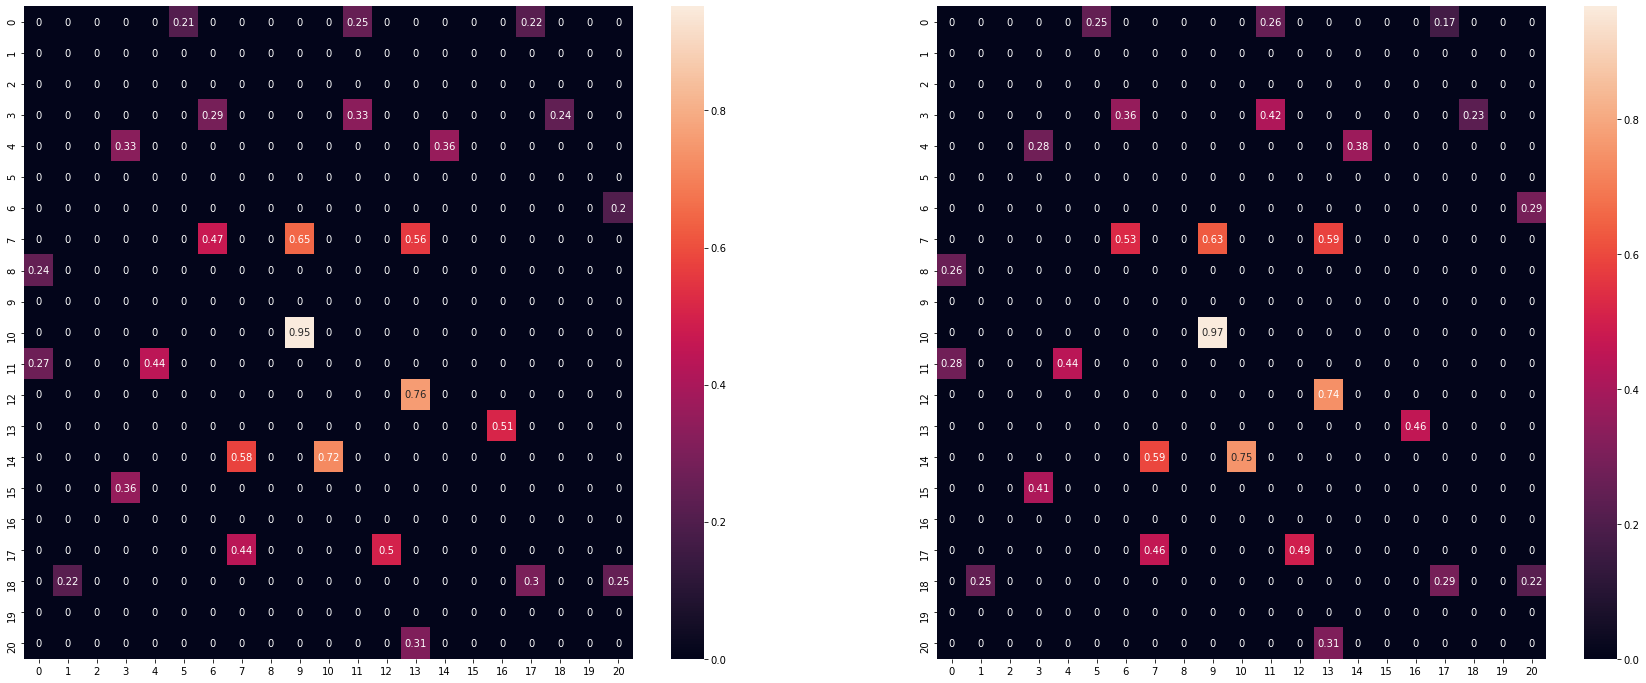

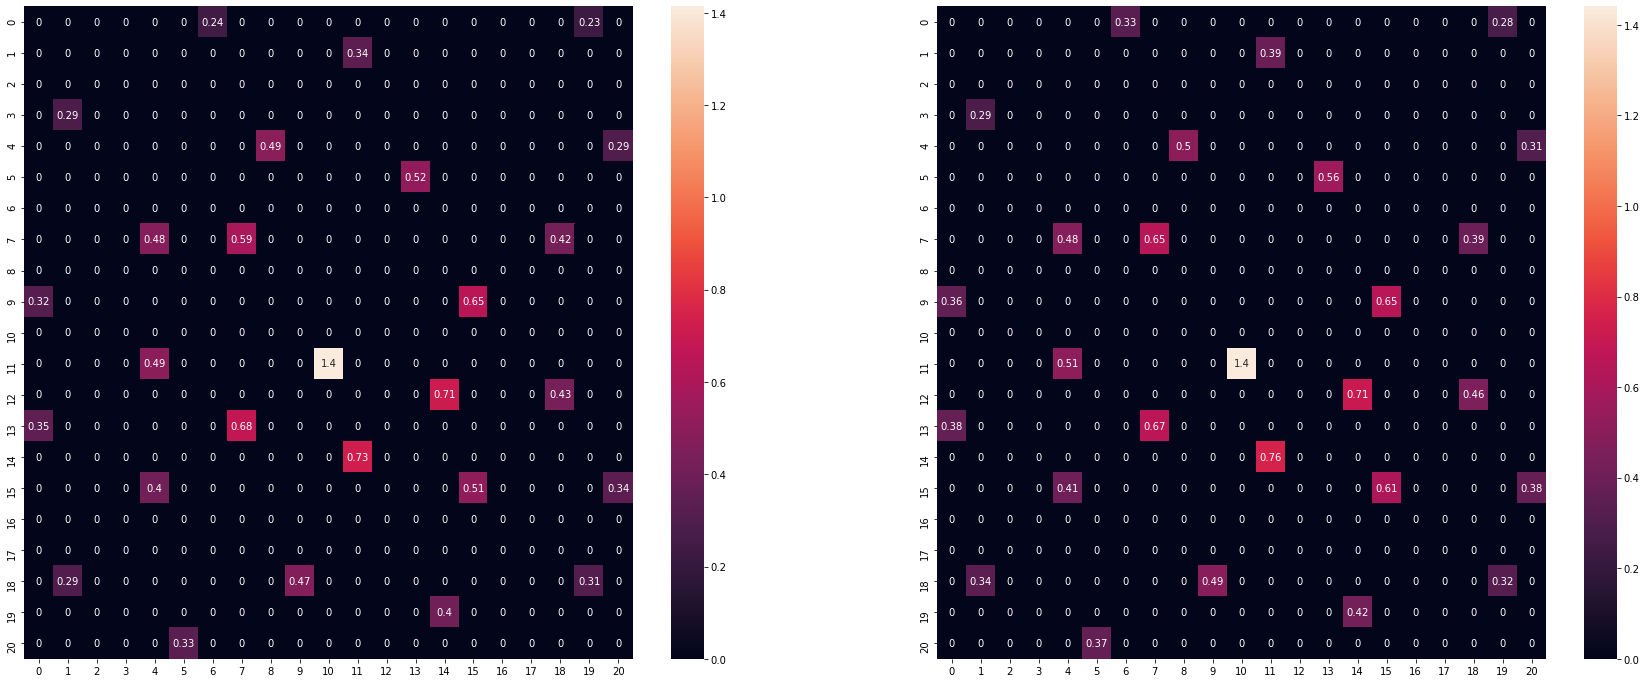

In [173]:
class SensorInputDataset(Dataset):
    '''Sensor reading input dataset -- for single TX power estimation
       output is a scaler value
    '''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir: directory
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        
    def __len__(self):
        return int(self.length / 4)

    def __getitem__(self, idx):
        matrix_name = f'{idx}.npy'
        matrix_path = os.path.join(self.root_dir, matrix_name)
        target_name = f'{idx}.power.npy'
        target_path = os.path.join(self.root_dir, target_name)
        matrix = np.load(matrix_path)
        target = np.load(target_path)
        if self.transform:
            matrix = self.transform(matrix)
        sample = {'index': idx, 'matrix': matrix, 'target': target}
        return sample


tf = T.Compose([
    UniformNormalize(Default.noise_floor),
    T.ToTensor()]
)


i, j = 10, 12
root_dir = './data/502train_crop'
train_sensor_input_dataset = SensorInputDataset(root_dir=root_dir, transform=tf)
train_sensor_input_dataloader = DataLoader(train_sensor_input_dataset, batch_size=16, shuffle=True, num_workers=3)
print('matrix shape:', train_sensor_input_dataset[i]['matrix'].shape)
print('target:', train_sensor_input_dataset[i]['target'])
print('target:', train_sensor_input_dataset[j]['target'])
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(30, 12))
sns.heatmap(train_sensor_input_dataset[i]['matrix'][0], annot=True, ax=ax0)
sns.heatmap(train_sensor_input_dataset[j]['matrix'][0], annot=True, ax=ax1)
print('data size:', train_sensor_input_dataset.__len__())

i, j = 10, 12
root_dir = './data/502test_crop'
test_sensor_input_dataset = SensorInputDataset(root_dir=root_dir, transform=tf)
test_sensor_input_dataloader = DataLoader(test_sensor_input_dataset, batch_size=16, shuffle=True, num_workers=3)
print('matrix shape:', test_sensor_input_dataset[i]['matrix'].shape)
print('target:', test_sensor_input_dataset[i]['target'])
print('target:', test_sensor_input_dataset[j]['target'])
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(30, 12))
sns.heatmap(test_sensor_input_dataset[i]['matrix'][0], annot=True, ax=ax0)
sns.heatmap(test_sensor_input_dataset[j]['matrix'][0], annot=True, ax=ax1)

# 3 Model

In [104]:
class PowerPredictor(nn.Module):
    '''The input is 1 x 21 x 21
       the output is a scaler between 0 and 5
    '''
    def __init__(self):
        super(PowerPredictor, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.conv2 = nn.Conv2d(4, 16, 5)
        self.conv3 = nn.Conv2d(16, 64, 5)
        self.conv4 = nn.Conv2d(64, 256, 5)
        self.conv5 = nn.Conv2d(256, 256, 5)
        self.fc = nn.Linear(256, 1)
        self.norm1 = nn.GroupNorm(2, 4)
        self.norm2 = nn.GroupNorm(8, 16)
        self.norm3 = nn.GroupNorm(32, 64)
        self.norm4 = nn.GroupNorm(128, 256)
        self.norm5 = nn.GroupNorm(128, 256)
    
    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        x = F.relu(self.norm4(self.conv4(x)))
        x = F.relu(self.norm5(self.conv5(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = PowerPredictor()
print(model)

PowerPredictor(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (norm1): GroupNorm(2, 4, eps=1e-05, affine=True)
  (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
  (norm4): GroupNorm(128, 256, eps=1e-05, affine=True)
  (norm5): GroupNorm(128, 256, eps=1e-05, affine=True)
)


In [109]:
class PowerPredictor2(nn.Module):
    '''The input is 1 x 21 x 21
       the output is a scaler between 0 and 5
    '''
    def __init__(self):
        super(PowerPredictor2, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.conv2 = nn.Conv2d(4, 16, 5)
        self.conv3 = nn.Conv2d(16, 64, 5)
        self.conv4 = nn.Conv2d(64, 256, 5)
        self.conv5 = nn.Conv2d(256, 256, 5)
        self.fc = nn.Linear(256, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = PowerPredictor2()
print(model)

PowerPredictor2(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [111]:
class PowerPredictor3(nn.Module):
    '''The input is 1 x 21 x 21
       the output is a scaler between 0 and 5
    '''
    def __init__(self):
        super(PowerPredictor3, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.conv2 = nn.Conv2d(4, 16, 5)
        self.conv3 = nn.Conv2d(16, 64, 5)
        self.conv4 = nn.Conv2d(64, 256, 5)
        self.conv5 = nn.Conv2d(256, 256, 5)
        self.fc = nn.Linear(256, 1)
        self.norm1 = nn.GroupNorm(2, 4)
        self.norm2 = nn.GroupNorm(8, 16)
    
    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = PowerPredictor3()
print(model)

PowerPredictor3(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (norm1): GroupNorm(2, 4, eps=1e-05, affine=True)
  (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
)


In [136]:
class PowerPredictor4(nn.Module):
    '''The input is 1 x 21 x 21, the output is a scaler between 0.5 and 5.5
       No fully connected layer in the end
    '''
    def __init__(self):
        super(PowerPredictor4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 128, 5)
        self.conv3 = nn.Conv2d(128, 32, 5)
        self.conv4 = nn.Conv2d(32, 8, 5)
        self.conv5 = nn.Conv2d(8, 1, 5)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        x = x.view(-1, self.num_flat_features(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    
model = PowerPredictor4()
device = torch.device('cuda')
sample = train_sensor_input_dataset[0]
X = torch.as_tensor(sample['matrix'])
X = X.unsqueeze(0)
y = sample['target']
y_pred = model(X)
y_pred = y_pred.data.cpu().numpy()
print('pred', y_pred)
print('model', model)

pred [[0.05998106]]
model PowerPredictor4(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(8, 1, kernel_size=(5, 5), stride=(1, 1))
)


# 4 Training

## 4.1 PowerPredictor

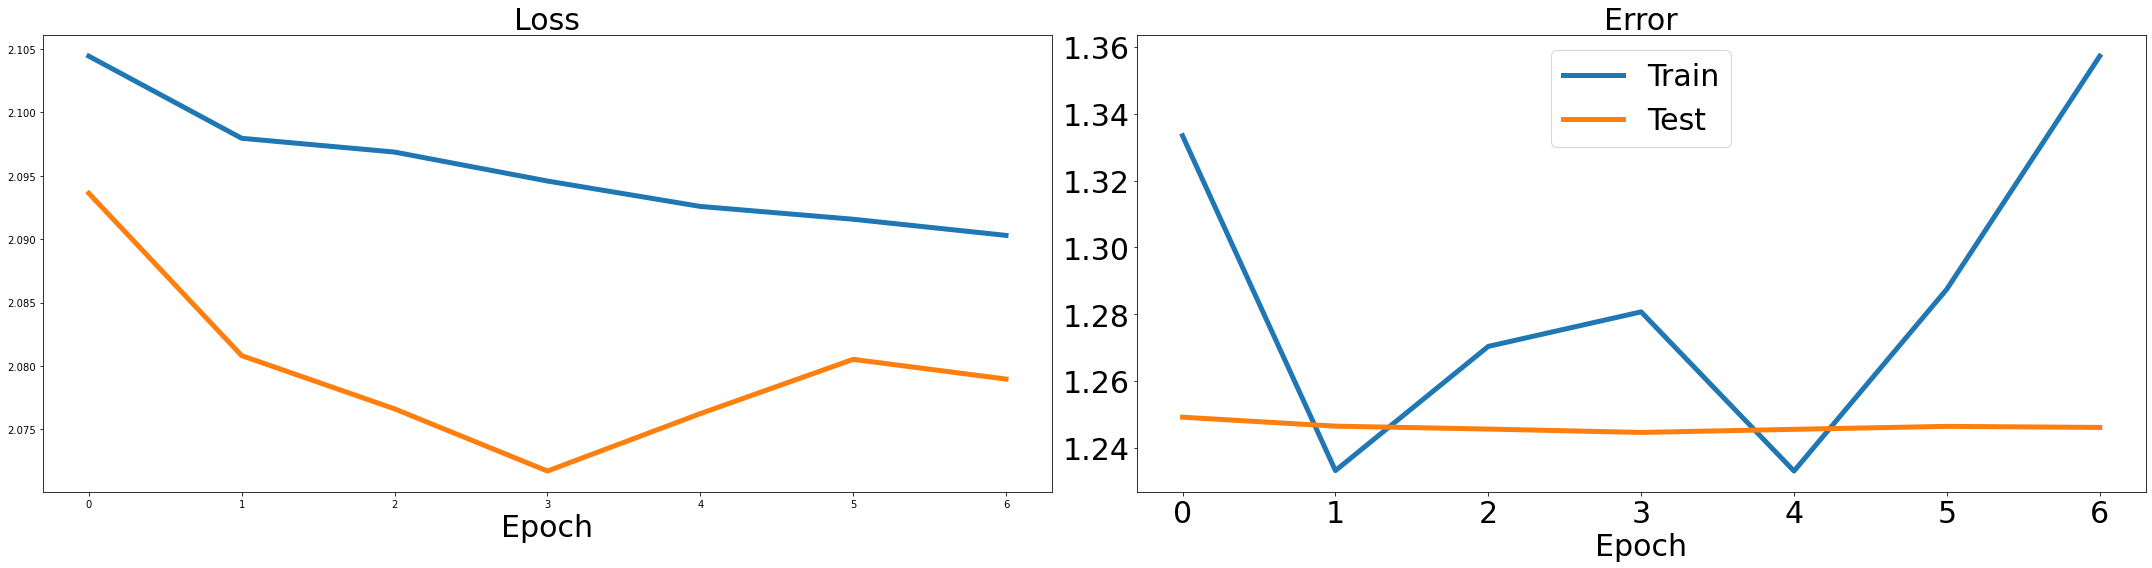

epoch = 7
t = 0, loss = 1.6019213199615479, error = 1.020113468170166
t = 200, loss = 1.9428584575653076, error = 1.1765817403793335
t = 400, loss = 2.0497143268585205, error = 1.2540779113769531
t = 600, loss = 2.064540386199951, error = 1.2209186553955078
t = 800, loss = 1.3202760219573975, error = 0.9960464239120483
t = 1000, loss = 1.498389720916748, error = 0.9481837749481201


KeyboardInterrupt: 

In [175]:
device = torch.device('cuda')
model = PowerPredictor()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print_every = 200
train_losses_epoch, train_errors_epoch = [], []
test_losses_epoch,  test_errors_epoch  = [], []

num_epochs = 20
for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses, train_errors = [], []
    test_losses, test_errors = [], []
    model.train()
    for t, sample in enumerate(train_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        if t % print_every == 0:
            y_pred = y_pred.data.cpu().numpy()
            errors = list(np.absolute(y_pred - np.array(sample['target'])))
            train_errors.extend(errors)
            print(f't = {t}, loss = {loss.item()}, error = {np.average(errors)}')
    
    model.eval()
    for t, sample in enumerate(test_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        test_losses.append(loss.item())
        y_pred = y_pred.data.cpu().numpy()
        errors = list(np.absolute(y_pred - np.array(sample['target'])))
        test_errors.extend(errors)
    
    scheduler.step()
    
    clear_output(True)
    train_losses_epoch.append(np.mean(train_losses))
    train_errors_epoch.append(np.mean(train_errors))
    test_losses_epoch.append(np.mean(test_losses))
    test_errors_epoch.append(np.mean(test_errors))
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses_epoch, label='Train', linewidth=5)
    plt.plot(test_losses_epoch, label='Test', linewidth=5)
    plt.subplot(1, 2, 2)
    plt.title('Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors_epoch, label='Train', linewidth=5)
    plt.plot(test_errors_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

## 4.2 PowerPredictor2

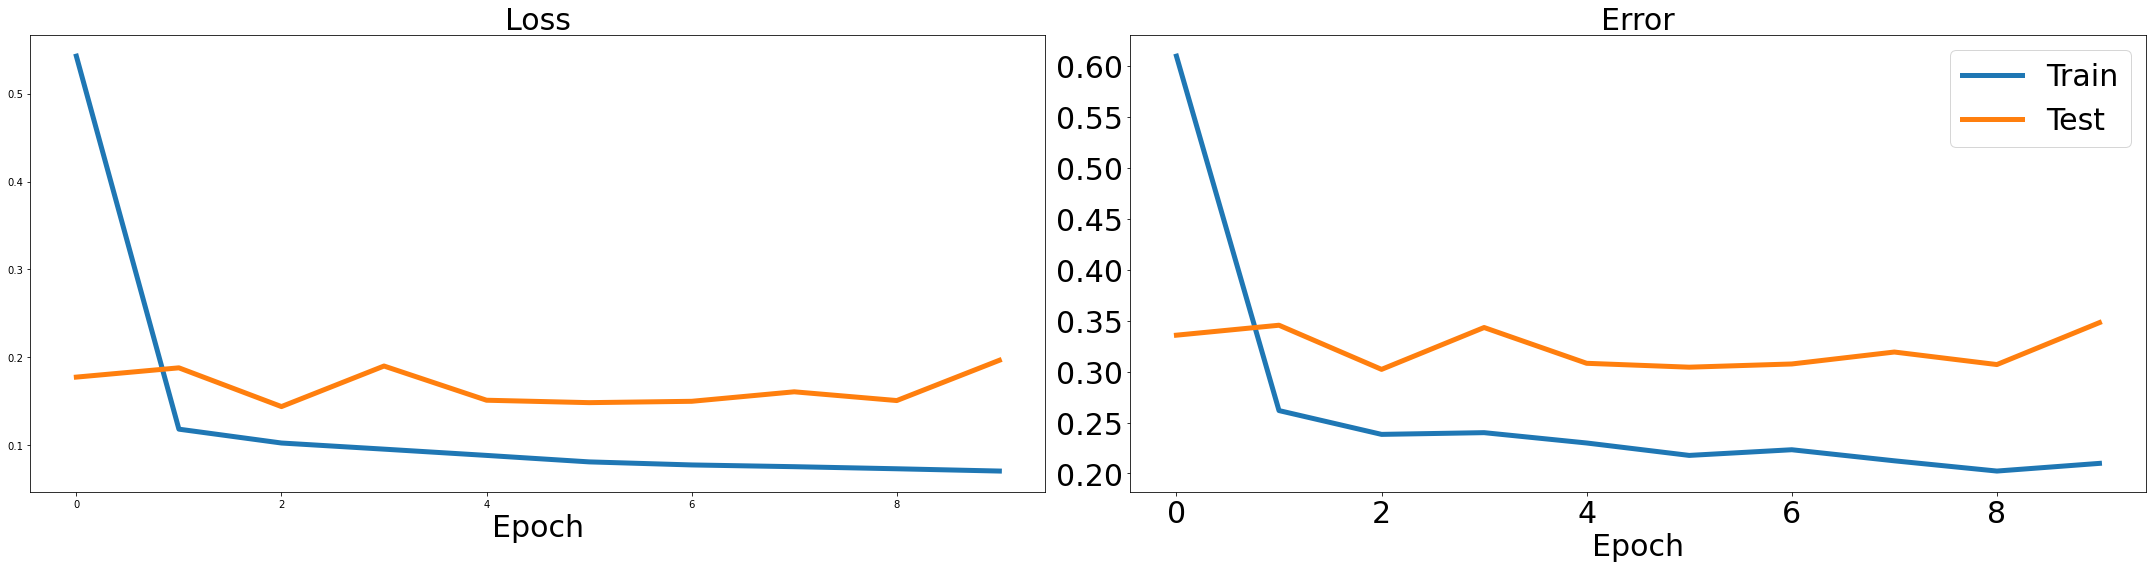

In [177]:
device = torch.device('cuda')
model = PowerPredictor2()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

print_every = 200
train_losses_epoch, train_errors_epoch = [], []
test_losses_epoch,  test_errors_epoch  = [], []

num_epochs = 10
for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses, train_errors = [], []
    test_losses, test_errors = [], []
    model.train()
    for t, sample in enumerate(train_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        if t % print_every == 0:
            y_pred = y_pred.data.cpu().numpy()
            errors = list(np.absolute(y_pred - np.array(sample['target'])))
            train_errors.extend(errors)
            print(f't = {t}, loss = {loss.item()}, error = {np.average(errors)}')
    
    model.eval()
    for t, sample in enumerate(test_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        test_losses.append(loss.item())
        y_pred = y_pred.data.cpu().numpy()
        errors = list(np.absolute(y_pred - np.array(sample['target'])))
        test_errors.extend(errors)
    
    scheduler.step()
    
    clear_output(True)
    train_losses_epoch.append(np.mean(train_losses))
    train_errors_epoch.append(np.mean(train_errors))
    test_losses_epoch.append(np.mean(test_losses))
    test_errors_epoch.append(np.mean(test_errors))
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses_epoch, label='Train', linewidth=5)
    plt.plot(test_losses_epoch, label='Test', linewidth=5)
    plt.subplot(1, 2, 2)
    plt.title('Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors_epoch, label='Train', linewidth=5)
    plt.plot(test_errors_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

## 4.3 PowerPredictor3

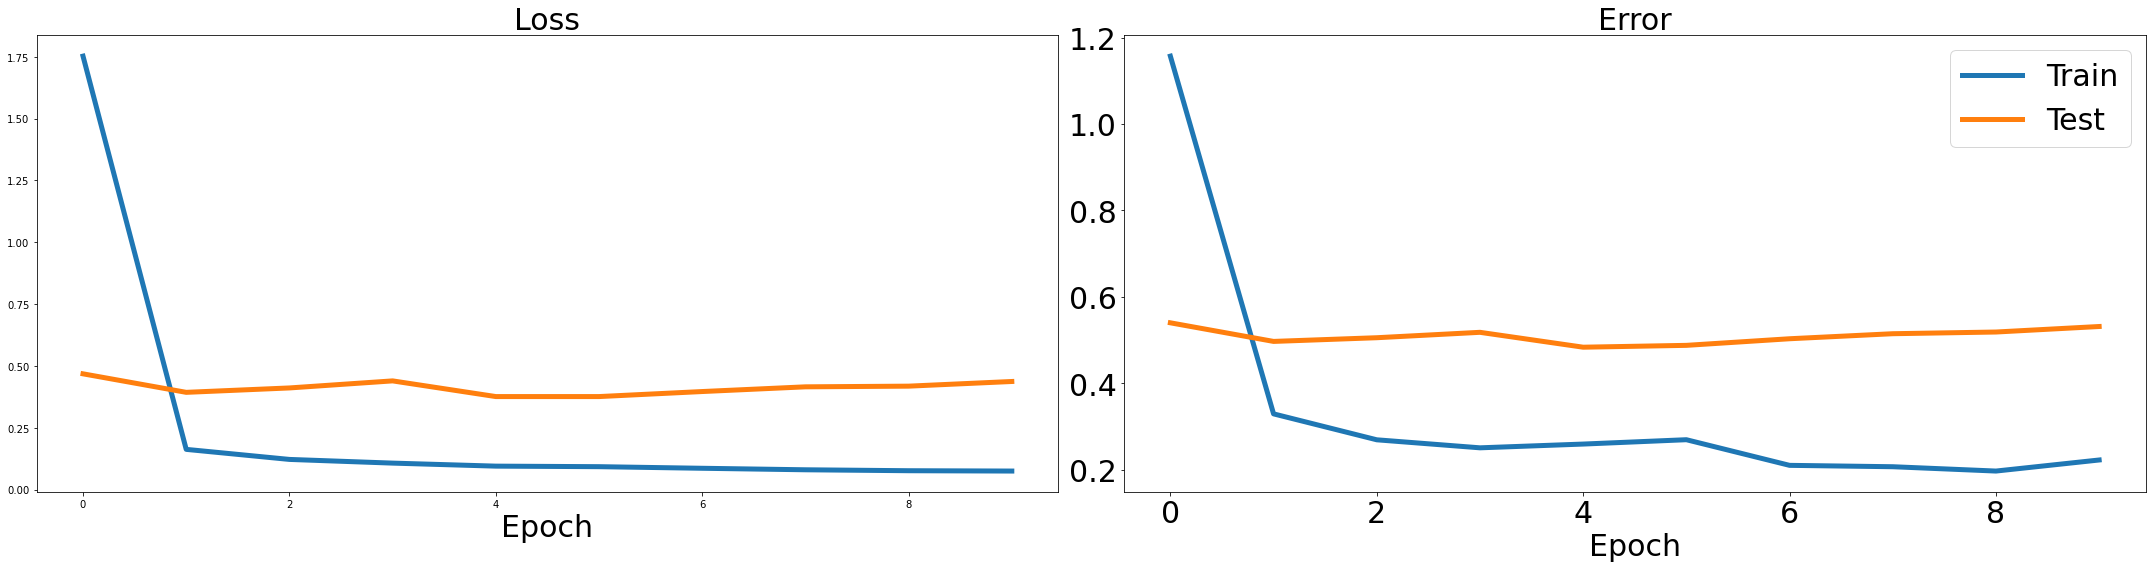

In [181]:
device = torch.device('cuda')
model = PowerPredictor3()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

print_every = 200
train_losses_epoch, train_errors_epoch = [], []
test_losses_epoch,  test_errors_epoch  = [], []

num_epochs = 10
for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses, train_errors = [], []
    test_losses, test_errors = [], []
    model.train()
    for t, sample in enumerate(train_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        if t % print_every == 0:
            y_pred = y_pred.data.cpu().numpy()
            errors = list(np.absolute(y_pred - np.array(sample['target'])))
            train_errors.extend(errors)
            print(f't = {t}, loss = {loss.item()}, error = {np.average(errors)}')
    
    model.eval()
    for t, sample in enumerate(test_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        test_losses.append(loss.item())
        y_pred = y_pred.data.cpu().numpy()
        errors = list(np.absolute(y_pred - np.array(sample['target'])))
        test_errors.extend(errors)
    
    scheduler.step()
    
    clear_output(True)
    train_losses_epoch.append(np.mean(train_losses))
    train_errors_epoch.append(np.mean(train_errors))
    test_losses_epoch.append(np.mean(test_losses))
    test_errors_epoch.append(np.mean(test_errors))
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses_epoch, label='Train', linewidth=5)
    plt.plot(test_losses_epoch, label='Test', linewidth=5)
    plt.subplot(1, 2, 2)
    plt.title('Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors_epoch, label='Train', linewidth=5)
    plt.plot(test_errors_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

## 4.4 PowerPredictor4

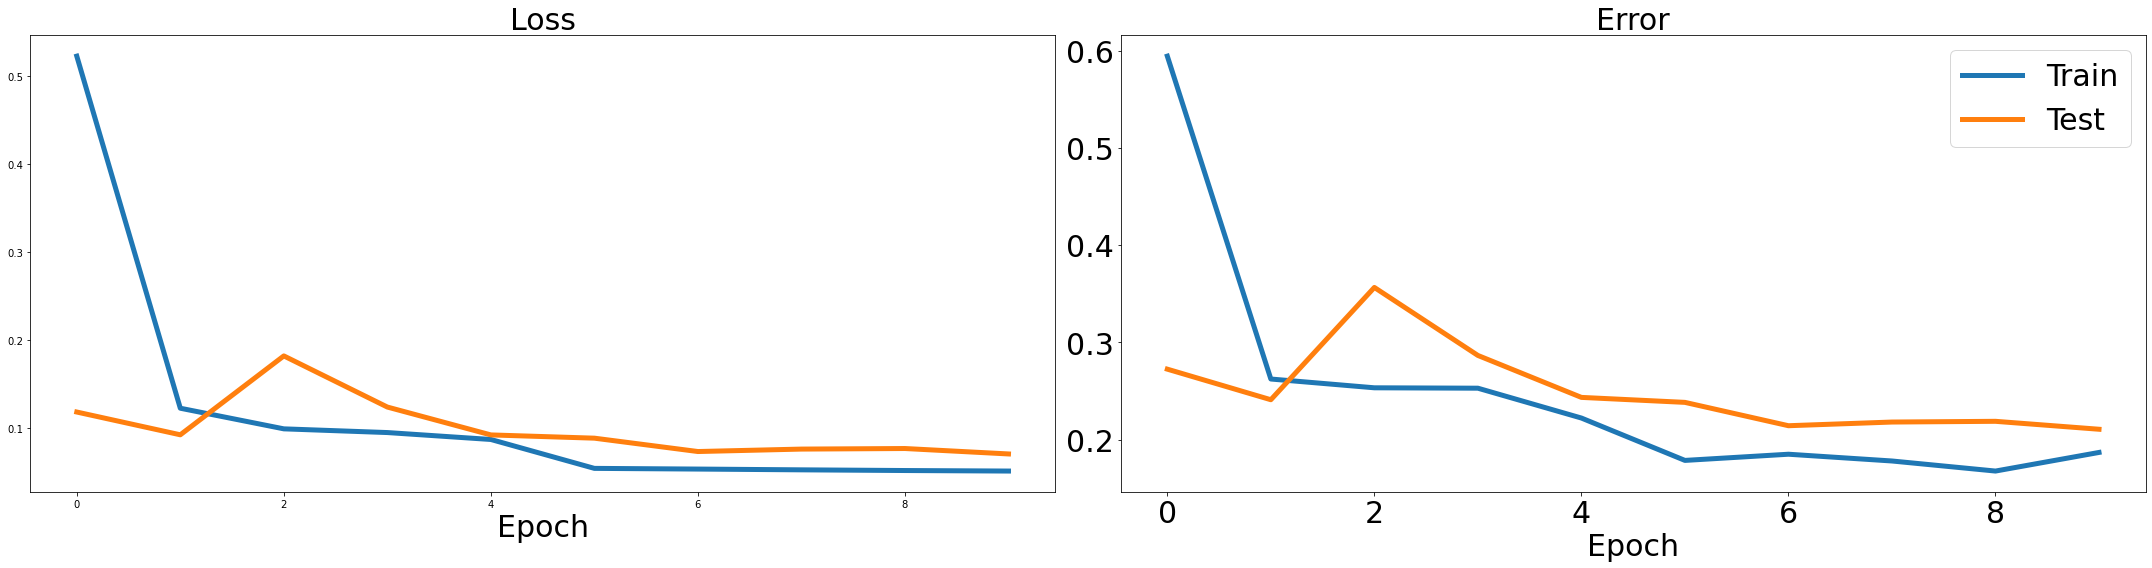

In [186]:
device = torch.device('cuda')
model = PowerPredictor4()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print_every = 200
train_losses_epoch, train_errors_epoch = [], []
test_losses_epoch,  test_errors_epoch  = [], []

num_epochs = 10
for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses, train_errors = [], []
    test_losses, test_errors = [], []
    model.train()
    for t, sample in enumerate(train_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        if t % print_every == 0:
            y_pred = y_pred.data.cpu().numpy()
            errors = list(np.absolute(y_pred - np.array(sample['target'])))
            train_errors.extend(errors)
            print(f't = {t}, loss = {loss.item()}, error = {np.average(errors)}')
    
    model.eval()
    for t, sample in enumerate(test_sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        
        y_pred = model(X)
        
        loss = loss_func(y_pred, y)
        test_losses.append(loss.item())
        y_pred = y_pred.data.cpu().numpy()
        errors = list(np.absolute(y_pred - np.array(sample['target'])))
        test_errors.extend(errors)
    
    scheduler.step()
    
    clear_output(True)
    train_losses_epoch.append(np.mean(train_losses))
    train_errors_epoch.append(np.mean(train_errors))
    test_losses_epoch.append(np.mean(test_losses))
    test_errors_epoch.append(np.mean(test_errors))
    plt.figure(figsize=(30, 8))
    plt.subplot(1, 2, 1)
    plt.title('Loss', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_losses_epoch, label='Train', linewidth=5)
    plt.plot(test_losses_epoch, label='Test', linewidth=5)
    plt.subplot(1, 2, 2)
    plt.title('Error', fontsize=30)
    plt.xlabel('Epoch', fontsize=30)
    plt.plot(train_errors_epoch, label='Train', linewidth=5)
    plt.plot(test_errors_epoch, label='Test', linewidth=5)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30)
    plt.tight_layout()
    plt.show()

# 5 Eval

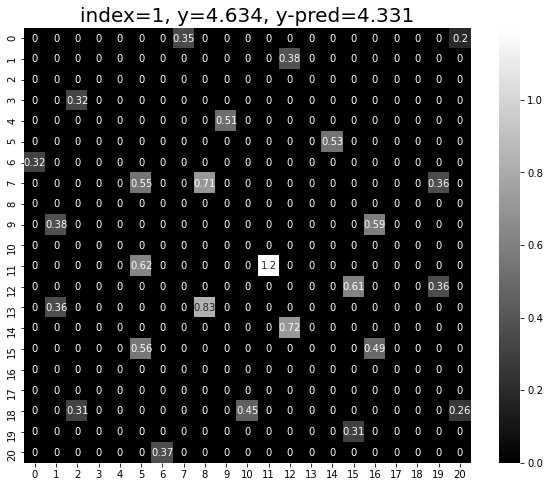

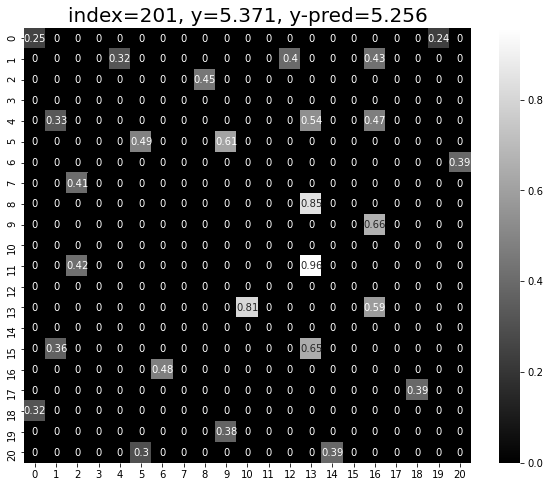

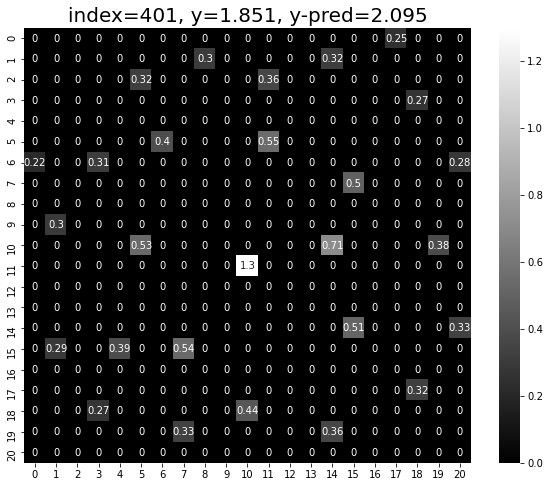

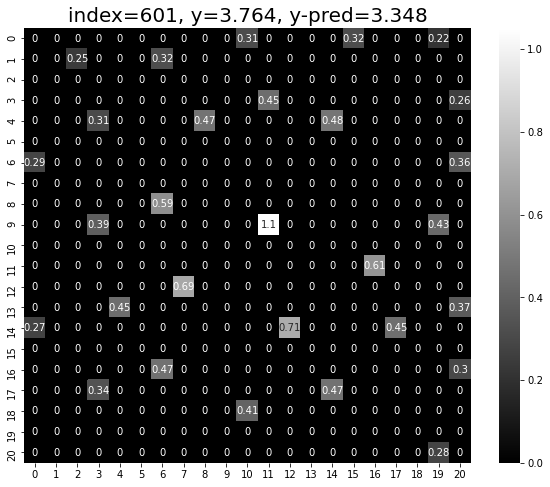

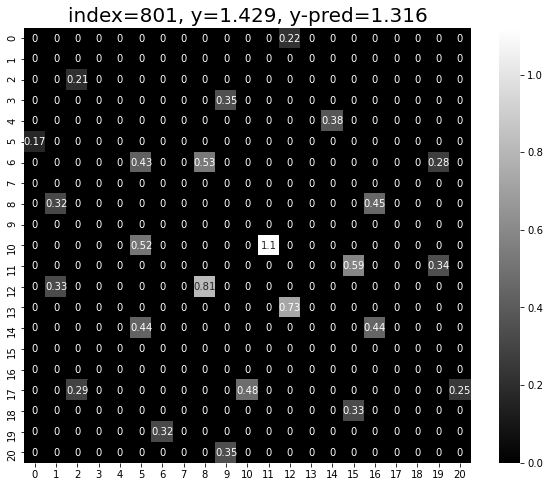

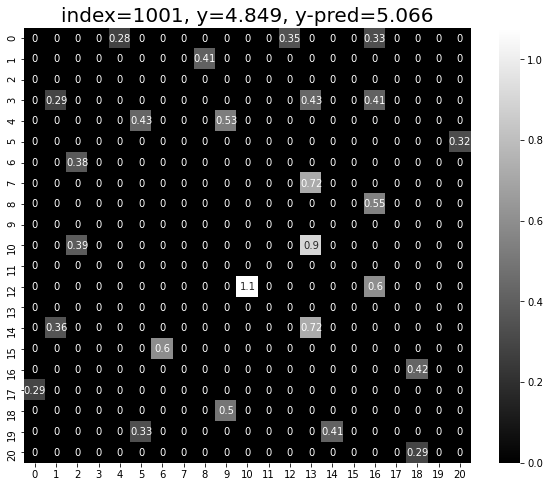

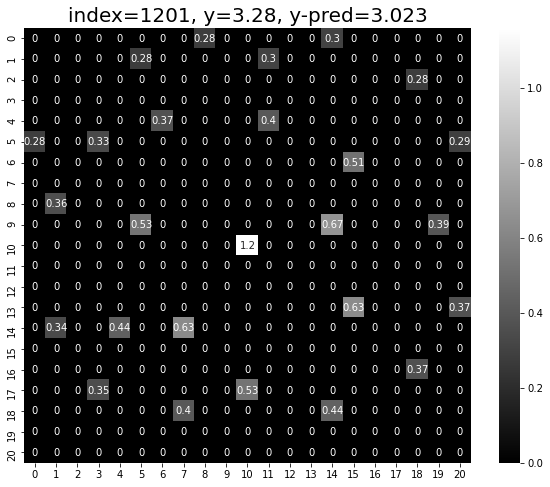

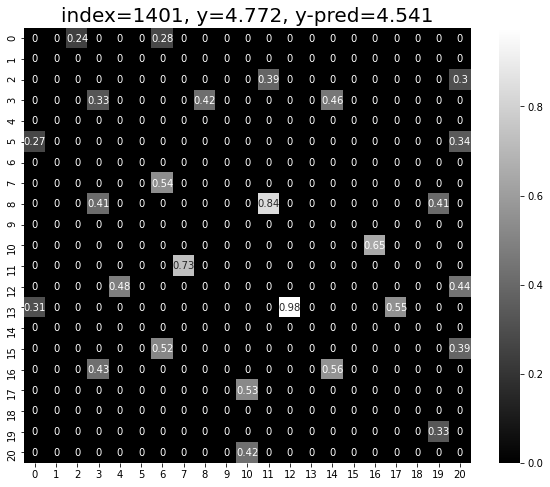

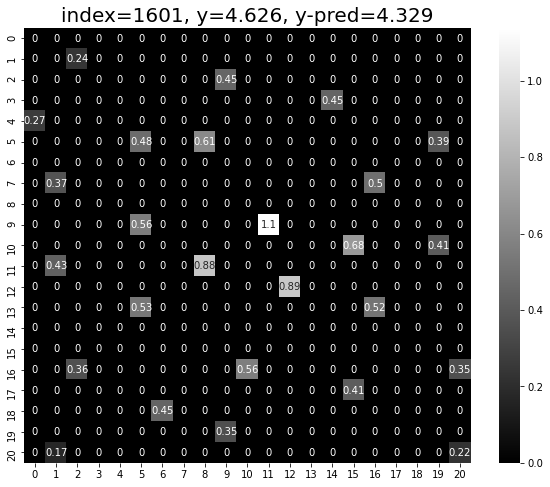

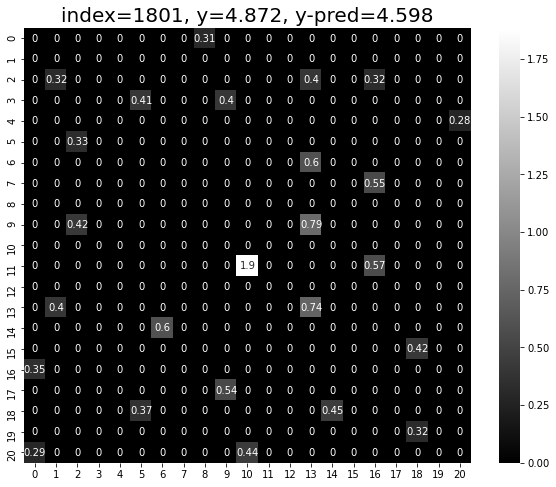

In [195]:
def one_sample(idx):
    device = torch.device('cuda')
#     sample = train_sensor_input_dataset[idx]
    sample = test_sensor_input_dataset[idx]
    X = torch.as_tensor(sample['matrix'])
    X = X.unsqueeze(0).to(device)
    y = sample['target']
    y_pred = model(X)
    y_pred = y_pred.data.cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    sns.heatmap(X[0][0].data.cpu().numpy(), cmap='gray', annot=True)
    ax.set_title(f'index={idx}, y={y[0]:.4}, y-pred={y_pred[0][0]:.4}', fontsize=20)


for i in range(1, 2000, 200):
    one_sample(i)

# 6 Processing Data

In [171]:
input_folder = 'data/502test'
output_folder = 'data/502test_crop'
if os.path.exists(output_folder) is False:
    os.mkdir(output_folder)

counter = 0
for folder in sorted(glob.glob(f'{input_folder}/*')):
#     print(folder)
    if counter % 1000 == 0:
        print(counter/10)
    num_samples = len(glob.glob(f'{folder}/*.json'))
    for i in range(num_samples):
        full_matrix_path = f'{folder}/{i}.npy'
        target_path = f'{folder}/{i}.target.npy'
#         print(full_matrix_path, target_path)
        full_matrix = np.load(full_matrix_path)
        target = np.load(target_path)
#         fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#         sns.heatmap(full_matrix, cmap='gray')
#         print(target)
        x, y = int(target[0][0]), int(target[0][1])
        crop = full_matrix[x-10:x+11, y-10:y+11]
#         fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#         sns.heatmap(crop, cmap='gray')
        np.save(f'{output_folder}/{counter}.npy', crop)
        np.save(f'{output_folder}/{counter}.target.npy', target)
        shutil.copy(f'{folder}/{i}.power.npy', f'{output_folder}/{counter}.power.npy')
        shutil.copy(f'{folder}/{i}.json', f'{output_folder}/{counter}.json')
        counter += 1
#     break

0.0
100.0
200.0
300.0
400.0
500.0
600.0
700.0
800.0
900.0
1000.0
1100.0
1200.0
1300.0
1400.0
1500.0
1600.0
1700.0
1800.0
1900.0
2000.0
2100.0
2200.0
2300.0
2400.0
2500.0
2600.0
2700.0
2800.0
2900.0
3000.0
3100.0
3200.0
3300.0
3400.0
3500.0
3600.0
3700.0
3800.0
3900.0
4000.0
4100.0
4200.0
4300.0
4400.0
4500.0
4600.0
4700.0
4800.0
4900.0
5000.0
5100.0
5200.0
5300.0
5400.0
5500.0
5600.0
5700.0
5800.0
5900.0
6000.0
6100.0
6200.0
6300.0
